In [75]:
import pandas as pd
from scipy.optimize import minimize_scalar
from pathlib import Path
from phreeqpython import PhreeqPython

In [76]:
"""
Create new PhreeqPython instance.

Include the argument for the location of the database file. In this case the CEMDATA18** database has been modified to utilize 
the Pitzer model for ion interactions since high ionic strength is encountered when Na2SO4 is added as a slag activator. This 
database has been included in repo.

**Lothenbach, B. et al., Cemdata18: a chemical thermodynamic database for hydrated Portland cements and 
alkali-activated materials, Cem. Concr. Res. 115 (2019) 472–506
"""

pp = PhreeqPython("CEMDATA18_Pitz_v1.dat", 
                  Path(r"Path-to-database-file"))

#### Read data for porewater elemental analysis as CSV file
##### Data should be structured for input as Phreeqc, for example:
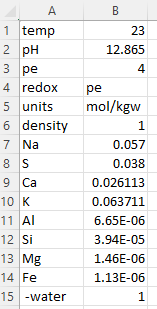
**Note that the pH value is arbitrary at this stage

In [77]:
lab_dat = pd.read_csv(r"CSV-file-path", 
                      header=None)

In [78]:
"""
Convert the dataframe to a dictionary
"""

lab_dict = dict(zip(lab_dat[0], lab_dat[1]))

In [79]:
"""
Input an estimated pH value. 
"""

lab_dict['pH'] = str(13.5)

In [80]:
"""
Input the OH- equivalent to the alkalinity titration (M), ie. equal to moles of H+ neutralized in titration.
"""
oh = 9.73e-2

In [81]:
def alk_titration(lab_dict):
   
    """
    Function that peforms the virtual alkalinity titration using the pp.change_pH() function, which adds HCl for acidification.
    The amount of HCl added is calculated from the change in Cl concentration.
    
    Inputs the dictionary lab_dict containing a Phreeqc SOLUTION format
    Returns the total alkalinity determined from virtual titration.
    """
    
    sol_lab = pp.add_solution(lab_dict)
    sol_init = sol_lab.copy()
    sol_tit = sol_lab.change_ph(4.5)
    alk_tit = sol_tit.total('Cl', units='mol') - sol_init.total('Cl', units='mol')
    
    return alk_tit 

In [82]:
def ph_to_alk(ph):
    
    """
    Function that takes pH as an argument and performs virtual alkalinity titration using the alk_titration function.
    
    Inputs pH.
    Returns the total alkalinity value for the input pH.
    """
    
    lab_dict['pH'] = str(ph)
    alk_ph = alk_titration(lab_dict)
    
    return alk_ph

In [83]:
"""
Lambda function with pH as input, that returns the difference between the total alkalinities from the virtual and 
actual titrations, is minimised, giving the pH value of the solution.
"""

bounds = (12, 14)
func  = lambda x: abs(ph_to_alk(x)-oh)
res = minimize_scalar(func, bounds=bounds)
lab_dict['pH'] = str(round(res.x, 3))

print("pH of solution is ", round(res.x, 3))

pH of solution is  12.865
